In [1]:
!pip install kagglehub

In [10]:
import kagglehub
import pandas as pd

# 1. Baixe o dataset (ele retorna o caminho para a pasta onde os arquivos foram baixados)
path = kagglehub.dataset_download("marlesson/news-of-the-site-folhauol")

# O caminho completo para o arquivo será algo como: '{path}/articles.csv'
file_path = f"{path}/articles.csv"

# 2. Abra o arquivo local com Pandas
df = pd.read_csv(file_path)

print(df.head())

                                               title  \
0  Lula diz que está 'lascado', mas que ainda tem...   
1  'Decidi ser escrava das mulheres que sofrem', ...   
2  Três reportagens da Folha ganham Prêmio Petrob...   
3  Filme 'Star Wars: Os Últimos Jedi' ganha trail...   
4  CBSS inicia acordos com fintechs e quer 30% do...   

                                                text        date   category  \
0  Com a possibilidade de uma condenação impedir ...  2017-09-10      poder   
1  Para Oumou Sangaré, cantora e ativista malines...  2017-09-10  ilustrada   
2  Três reportagens da Folha foram vencedoras do ...  2017-09-10      poder   
3  A Disney divulgou na noite desta segunda-feira...  2017-09-10  ilustrada   
4  O CBSS, banco da holding Elopar dos sócios Bra...  2017-09-10    mercado   

  subcategory                                               link  
0         NaN  http://www1.folha.uol.com.br/poder/2017/10/192...  
1         NaN  http://www1.folha.uol.com.br/ilustrada/

In [11]:
#Crie um ranking das organizações que mais apareceram na seção "Mercado" no primeiro trimestre de 2015.
df['date'] = pd.to_datetime(df.date)
df_filtrado = df[(df["date"].dt.year == 2015) & (df["category"].str.lower() == "mercado")]


In [36]:
from transformers import BertForTokenClassification, DistilBertTokenizerFast, pipeline
model = BertForTokenClassification.from_pretrained('monilouise/ner_pt_br')
tokenizer = DistilBertTokenizerFast.from_pretrained('neuralmind/bert-base-portuguese-cased'
                                                    , model_max_length=512
                                                    , do_lower_case=False
                                                    )
ner_pipeline = pipeline('ner', 
                        model=model, 
                        tokenizer=tokenizer, 
                        grouped_entities=True, 
                        aggregation_strategy="average", 
                        framework="pt", 
                        device="cuda:0")


Some weights of the model checkpoint at monilouise/ner_pt_br were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
The tokenizer class you load from this check

In [37]:
def extract_entities(text, max_tokens=512):
    entities = []
    words = text.split()
    blocks = []
    for word in words:
        blocks.append(word)
        text_truncated = " ".join(blocks)
        tokens = tokenizer(text_truncated, return_tensors="pt", truncation=False)
        if tokens.input_ids.shape[1] >= max_tokens:
            blocks.pop()
            text_truncated = " ".join(blocks)
            entities.extend(ner_pipeline(text_truncated))
            blocks = [word]
    entities.extend(ner_pipeline(text_truncated))
    return entities

In [21]:
!pip install wordcloud

In [38]:
from tqdm.auto import tqdm

all_entities = []
for text in tqdm(df_filtrado['text']):
    all_entities.extend(extract_entities(text))

100%|██████████| 8442/8442 [1:00:58<00:00,  2.31it/s]


In [43]:
ranking = [entity['word'] for entity in all_entities if entity['entity_group'] ==  "ORG" and len(entity['word']) > 1]

In [44]:
all_entities

[{'entity_group': 'ORG',
  'score': np.float32(0.64472735),
  'word': 'Whats',
  'start': 23,
  'end': 28},
 {'entity_group': 'ORG',
  'score': np.float32(0.885894),
  'word': '##App',
  'start': 28,
  'end': 31},
 {'entity_group': 'LOC',
  'score': np.float32(0.9532261),
  'word': 'Grã -',
  'start': 367,
  'end': 371},
 {'entity_group': 'LOC',
  'score': np.float32(0.970656),
  'word': 'Bretanha',
  'start': 371,
  'end': 379},
 {'entity_group': 'LOC',
  'score': np.float32(0.9871193),
  'word': 'Índia',
  'start': 384,
  'end': 389},
 {'entity_group': 'LOC',
  'score': np.float32(0.9881253),
  'word': 'Colômbia',
  'start': 394,
  'end': 402},
 {'entity_group': 'LOC',
  'score': np.float32(0.98656476),
  'word': 'México',
  'start': 407,
  'end': 413},
 {'entity_group': 'ORG',
  'score': np.float32(0.9406857),
  'word': 'Folha',
  'start': 502,
  'end': 507},
 {'entity_group': 'ORG',
  'score': np.float32(0.5744986),
  'word': 'Daily',
  'start': 604,
  'end': 609},
 {'entity_group'

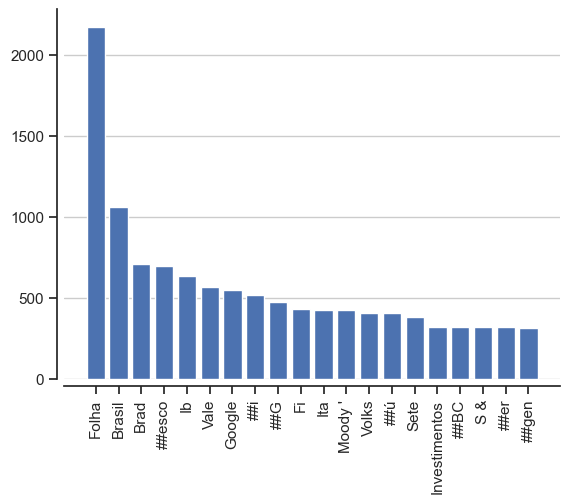

In [41]:
from typing import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
top_10 = dict(Counter(ranking).most_common(20))
ax = plt.bar(top_10.keys(), top_10.values())
sns.despine(offset=5)
plt.grid(":", axis='y')
plt.xticks(rotation=90);


In [42]:
Counter(ranking).most_common()

[('Folha', 2174),
 ('Brasil', 1059),
 ('Brad', 709),
 ('##esco', 697),
 ('Ib', 635),
 ('Vale', 565),
 ('Google', 550),
 ('##i', 519),
 ('##G', 473),
 ('Fi', 432),
 ('Ita', 427),
 ("Moody '", 425),
 ('Volks', 409),
 ('##ú', 408),
 ('Sete', 385),
 ('Investimentos', 323),
 ('##BC', 320),
 ('S &', 318),
 ('##er', 318),
 ('##gen', 317),
 ('##S', 313),
 ('Facebook', 307),
 ('BM &', 300),
 ('Pactual', 298),
 ('##AS', 298),
 ('BTG', 293),
 ('Times', 292),
 ('Ub', 280),
 ('Apple', 275),
 ('FBovespa', 273),
 ('Amazon', 268),
 ('Banco do', 265),
 ('Itaú', 249),
 ('AB', 247),
 ('Santa', 246),
 ('##nder', 241),
 ('BR', 227),
 ('Unibanco', 225),
 ('##M', 223),
 ('Ele', 221),
 ("Standard & Poor '", 217),
 ('##V', 216),
 ('##tch', 205),
 ('##ers', 200),
 ('Wh', 192),
 ('Corretora', 191),
 ('InBev', 191),
 ('Blo', 189),
 ('##BS', 188),
 ('CS', 183),
 ('##wa', 183),
 ('##omberg', 181),
 ('Banco', 175),
 ('##Miller', 174),
 ('Al', 173),
 ('##p', 167),
 ('##s', 165),
 ('Financial', 161),
 ('Grupo', 159),


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_wordcloud_entities_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_docs = topic_news.spacy_ner.apply(lambda l : [w.replace(" ", "_") for w in l])
    list_of_words = chain(*list_of_docs)
    string_complete = ' '.join(list_of_words)
    if not len(string_complete):
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_entities_for_a_topic(idx, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx }")
fig.tight_layout()